In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from sklearn.metrics import v_measure_score
from sklearn.decomposition import KernelPCA
from tck.TCK import TCK
from tck.datasets import DataLoader

np.random.seed(0)
# Set the colormap for the histogram plot
cmap = plt.cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

Load the data.

In [2]:
downloader = DataLoader()
Xtr, Ytr, Xte, Yte = downloader.get_data('Japanese_Vowels') 

# Since we are doing clustering, we do not need the train/test split
X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)

Loaded Japanese_Vowels dataset.
Data shapes:
 Xtr: (270, 29, 12)
 Ytr: (270, 1)
 Xte: (370, 29, 12)
 Yte: (370, 1)


Add missing data (40%).

In [3]:
mask = np.random.choice([0, 1], size=X.shape, p=[0.6, 0.4])
X[mask == 1] = np.nan

Compute TCK.

In [4]:
tck = TCK(G=40, C=20)
K = tck.fit(X).predict(mode='tr-tr')
print(f"K shape: {K.shape}")

The dataset contains missing data

Training the TCK using the following parameters:
	C = 20, G = 40
	Number of MTS for each GMM: 512 - 640 (80 - 100 percent)
	Number of attributes sampled from [2, 11]
	Length of time segments sampled from [6, 23]




Computing TCK (tr-tr): 100%|██████████| 760/760 [00:52<00:00, 14.52it/s]


K shape: (640, 640)


Visualize the kernel.

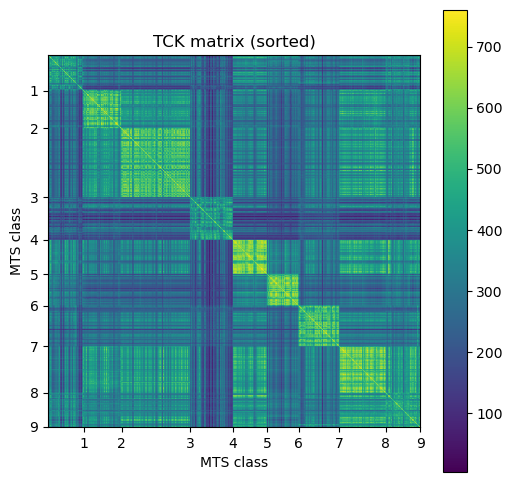

In [5]:
idx_sorted = np.argsort(Y[:,0])
K_sorted = K[:,idx_sorted][idx_sorted,:]
fig =  plt.figure(figsize=(6,6))
h = plt.imshow(K_sorted)
plt.title("TCK matrix (sorted)")
plt.colorbar(h)
class_num, _ = np.histogram(Y[:,0], bins=len(np.unique(Y)))
pos = np.cumsum(class_num)
plt.xticks(pos, np.unique(Y))
plt.yticks(pos, np.unique(Y))
plt.xlabel("MTS class")
plt.ylabel("MTS class")
plt.show()

Perform dimensionality reduction with Kernel PCA using TCK as the kernel.

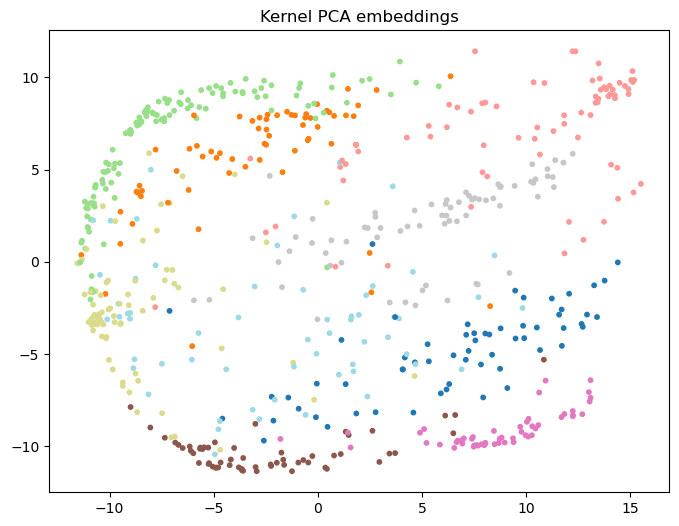

In [6]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(K)
fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.show()

Compute the dissimilarity matrix needed for clustering.

In [7]:
Dist = 1.0 - (K+K.T)/(2.0*K.max())
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

Hierarchical clustering.

In [8]:
distArray = ssd.squareform(Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t=2.0, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))

Found 11 clusters


Evaluate the agreement between class and cluster labels.

In [9]:
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

Normalized Mutual Information (v-score): 0.759


Plot the dendrogram.

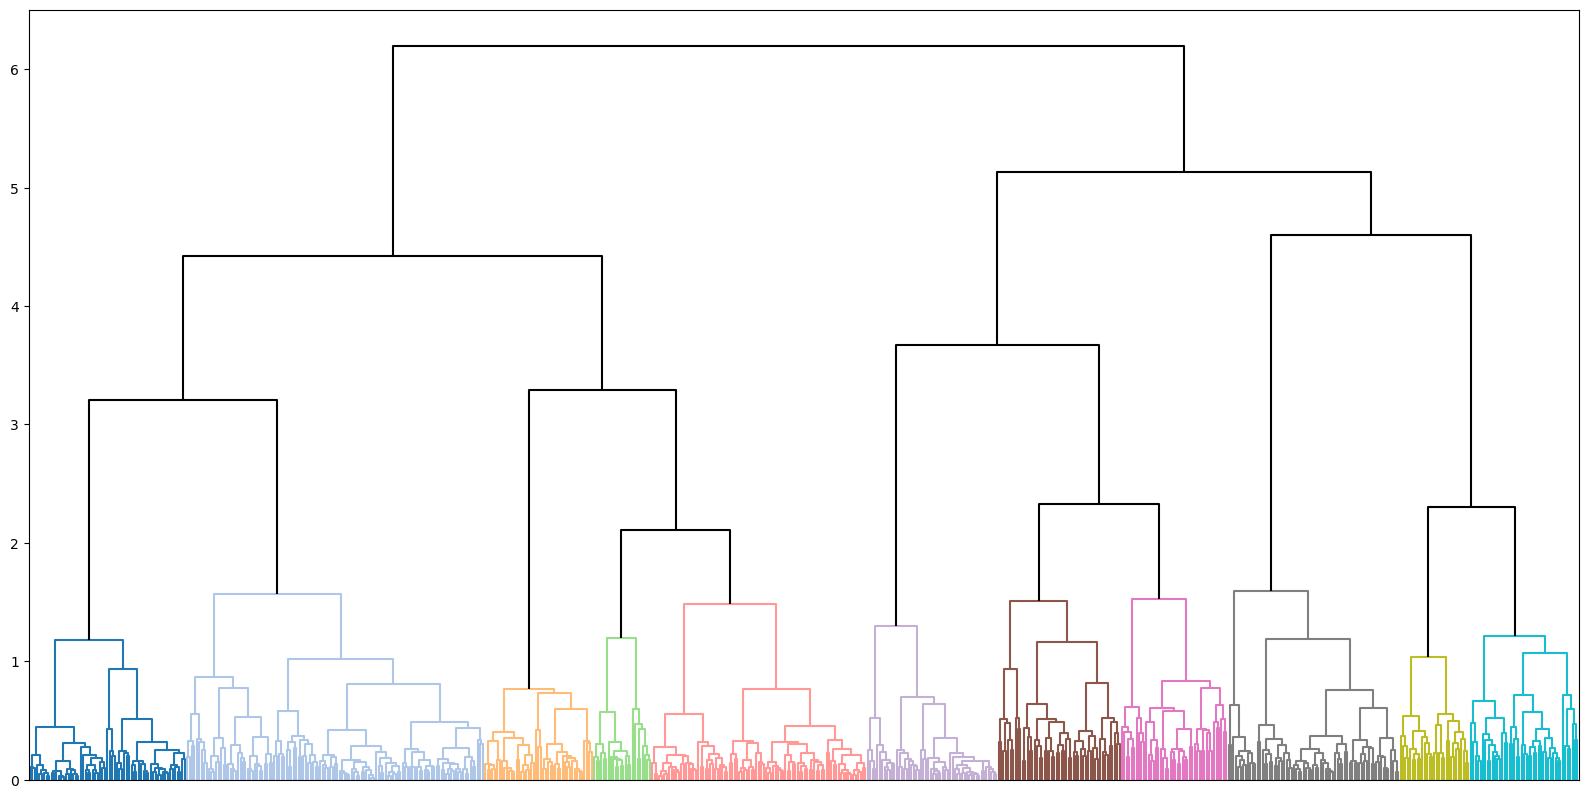

N. clusters:  11


In [10]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=2.0, labels=None, above_threshold_color='k')
plt.xticks([])
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)